A simple notebook demonstrates the application to the linear Gaussian model $x \mid \theta \sim \mathcal{N}(\theta, \Sigma_n)$. We can decompose this into two conditional models:

$$
\theta^* \mid \theta \sim \mathcal{N}(\theta, \Sigma_{\theta^*}), \quad x \mid \theta^* \sim \mathcal{N}(\theta^*, \Sigma_n - \Sigma_{\theta^*}).
$$

To learn the Fisher score, we use the true score from the first part of the model and draw samples from the joint distribution $p(\theta, \theta^*, x)$. The loss function is given by:

$$
L = \mathbb{E}_{p(x, \theta, \theta^*)} \left[ \left( s(x, \theta) - \nabla_{\theta} \log p(\theta^* \mid \theta) \right)^2 \right],
$$

where $s(x, \theta)$ is the score estimator we aim to learn.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
import os
sys.path.append('/home/csui1/workspace/fsm/FisherScoreMatching')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
#torch 
import torch
import torch.nn as nn
from fsm.models import LinearGaussianModel
from fsm.plot_utils import downsample_scatter_plot,plot_vector_field
from fsm.regressor import FSM_Regressor
from fsm.tools import to_numpy,to_tensor

Define and Decompose the model

In [21]:
model_cov = np.array([[1, 0.5],
                      [0.5, 1]])
dim = 2
epsilon_cov = 0.40*np.eye(dim)
rest_cov = model_cov - epsilon_cov

full_model = LinearGaussianModel(cov = model_cov)
latent_model = LinearGaussianModel(cov = epsilon_cov)
rest_model = LinearGaussianModel(cov = rest_cov)

Generate Training set

In [22]:
sample_size = 100000

#theta prior 
theta_latent = np.random.uniform(-1, 1, size=(sample_size,dim))
theta, latent_score = latent_model.sample_and_score(theta_latent)
x = rest_model.sample(theta)
true_score = full_model.fisher_score(x,theta_latent)

In [23]:
theta.shape, latent_score.shape, x.shape, true_score.shape

((100000, 2), (100000, 2), (100000, 2), (100000, 2))

In [24]:
train_input = np.concatenate((x,theta_latent), axis=1)
train_ouput = latent_score.copy()

train_input = to_tensor(train_input)
train_ouput = to_tensor(train_ouput)

train_input.shape, train_ouput.shape

(torch.Size([100000, 4]), torch.Size([100000, 2]))

Train Model

In [25]:
activation = nn.ELU
f = nn.Sequential(
        nn.Linear(train_input.shape[1], 64),
        activation(),
        nn.Linear(64, 64),
        activation(),
        nn.Linear(64, 64),
        activation(),
        nn.Linear(64, train_ouput.shape[1]),                      
    )

fm_regressor = FSM_Regressor(f, device='cuda')
fm_regressor.train(train_input, train_ouput, lr=1e-2, epochs=1000,verbose=True)

Iter 0000 | Total Loss 2.551276
Iter 0100 | Total Loss 1.160944
Iter 0200 | Total Loss 1.160453
Iter 0300 | Total Loss 1.160265
Iter 0400 | Total Loss 1.160378
Iter 0500 | Total Loss 1.159976
Iter 0600 | Total Loss 1.159783
Iter 0700 | Total Loss 1.159640
Iter 0800 | Total Loss 1.159955
Iter 0900 | Total Loss 1.159317


In [26]:
fs_prediction = fm_regressor.predict(train_input)

Plot the network output against the true score and the latent score used during training.

Text(0.5, 1.0, 'Fisher Score Prediction vs Latent Score Used for Training')

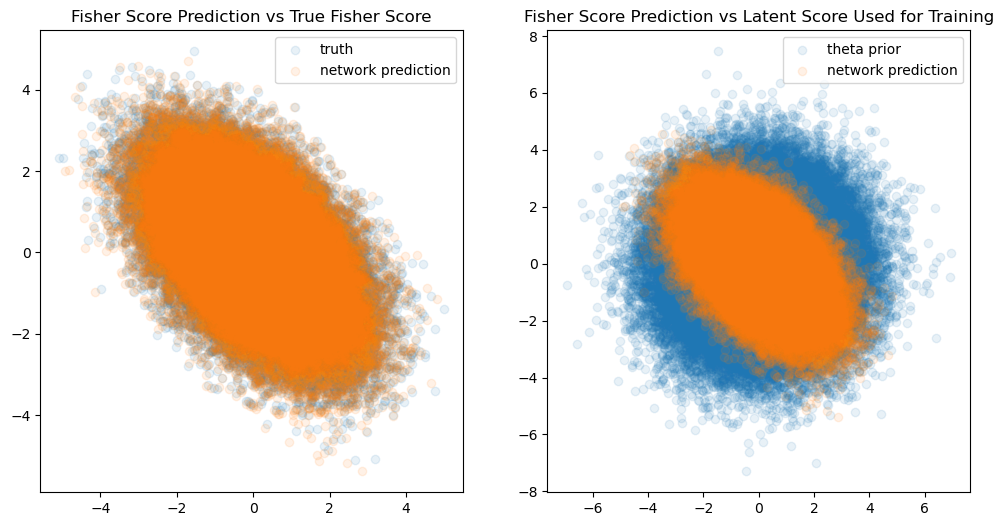

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(true_score[:, 0], true_score[:, 1], alpha=0.1, label='truth')
axs[0].scatter(fs_prediction[:, 0], fs_prediction[:, 1], alpha=0.1, label='network prediction')
axs[0].legend()

axs[0].set_title('Fisher Score Prediction vs True Fisher Score')

axs[1].scatter(latent_score[:, 0], latent_score[:, 1], alpha=0.1, label='theta prior')
axs[1].scatter(fs_prediction[:, 0], fs_prediction[:, 1], alpha=0.1, label='network prediction')
axs[1].legend()

axs[1].set_title('Fisher Score Prediction vs Latent Score Used for Training')


Generate Test set

In [29]:
theta_fid = np.random.uniform(0, 3, size=(dim,))
x_fid = rest_model.sample(theta_fid)

Plot fisher score at on mock observation

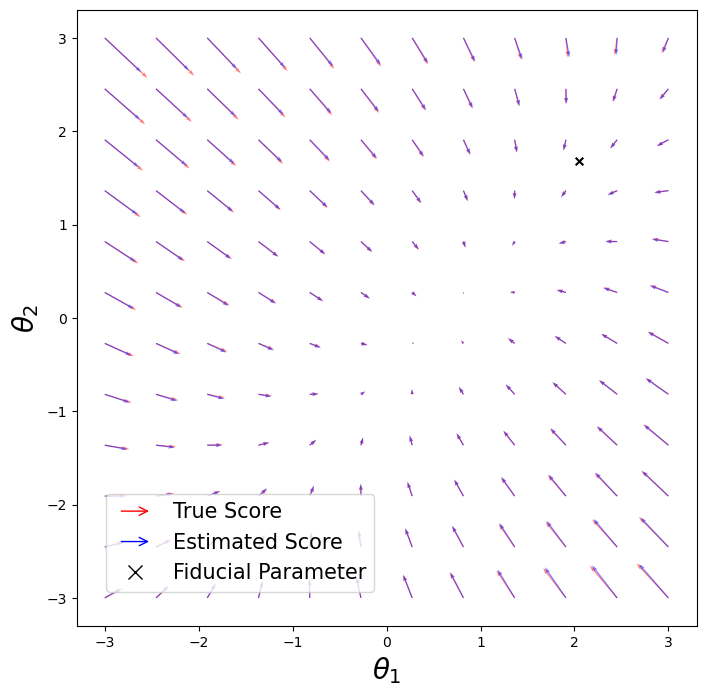

In [34]:
from fsm.plot_utils import FancyArrowPatch, Line2D, HandlerArrow, HandlerEllipse,Ellipse

fig,ax = plt.subplots(1,1,figsize=(8,8))
plot_range = (-3, 3)
scale = 100

ax = plot_vector_field(plot_range,plot_range, 
                  lambda theta: full_model.fisher_score(x_fid, theta),
                  num_points=12,ax=ax,color='red',alpha=0.5, label='True Score', width=0.002,scale=scale)

ax = plot_vector_field(plot_range,plot_range,
                  lambda theta: fm_regressor.cond_predict(x_fid,theta),
                  num_points=12,ax=ax,color='blue',alpha=0.5, label='Estimated Score', width=0.002,scale=scale)
ax.scatter(theta_fid[0], theta_fid[1],marker='x', color='black', s=30, label=r'Fiducial $\theta$')

ax.set_xlabel(r'$\theta_1$', fontsize=20)
ax.set_ylabel(r'$\theta_2$',fontsize=20)


red_arrow = FancyArrowPatch((0, 0), (2,0), color='red', arrowstyle='->')
blue_arrow = FancyArrowPatch((0, 0), (2, 0), color='blue', arrowstyle='->')
black_line = Line2D([0], [0], color='black', linewidth=2)
black_marker = Line2D([0], [0], color='black', marker='x', linestyle='None', markersize=10)

fig.legend([red_arrow, blue_arrow,black_marker], ['True Score', 'Estimated Score','Fiducial Parameter'],
          handler_map={FancyArrowPatch: HandlerArrow(),Ellipse: HandlerEllipse()},loc=(0.15, 0.15), fontsize=15)